### HS300 backtest
1. Data collection: HS300.
2. Data cleaning: Remove stocks with missing value.
3. Label making: VWAP ROI of between T and T + 11.
4. Data preprocessing: 3MAD, z-score etc.
5. ROI dataframe making: HS300, CS500, CS1000 etc.
6. Modeling: MLP, GBDT, GRU, AGRU. *(Rolling position adjustment)*
7. Ensembling: according to past 60 days' ICIR.
8. Backtesting.

### Rolling training
- Begin date: 20180112
- Test begin date: 20230111
- End date: 20240419

In [89]:
# Modeling
import tensorflow as tf
# from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tensorflow.keras.models import Model # , Sequential
from tensorflow.keras.layers import Dense, Attention, GRU, Input
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping # , LearningRateScheduler

from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import date, timedelta
import psutil
import os

# Get the current process ID of the IPython kernel
pid = os.getpid()
# Get the process associated with the IPython kernel
process = psutil.Process(pid)

from cylib.apis.all_api import *
from tqdm import tqdm  # For status process bar
from IPython.display import clear_output
import baostock as bs
import pickle

# Suppress the warning
warnings.filterwarnings(
    "ignore", 
    category=pd.core.common.SettingWithCopyWarning)

zscore = StandardScaler()

# Suppress the warning
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
Main_bactest = False
Online = False
path_Main = "/home/huh/"
path_HS300_Rolling = "/home/huh/Stage-2/HS300-Rolling/"
path_HS300_Rolling_pic = "/home/huh/Stage-2/HS300-Rolling/Loss-pic/"

begin_date = "20180101"
end_date = "20240430"
today_date = str(date.today())
if Main_bactest:
    end_date = today_date

In [90]:
def RAM_USAGE():
    # Get the memory usage of the IPython kernel in MB
    ram_usage = process.memory_info().rss / (1024 * 1024)
    print(f"RAM Usage: {ram_usage} MB")
RAM_USAGE()

RAM Usage: 4226.82421875 MB


In [91]:
if not Online:
    date_all = pd.read_csv(path_HS300_Rolling + 'date_all.csv', 
                           index_col=0, 
                           parse_dates=True).index
    date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)

    # Load the stocks code from the file
    with open(path_HS300_Rolling + 'stocks_code.pkl', 'rb') as file:
        stocks_code = pickle.load(file)

    price = pd.read_csv(path_HS300_Rolling + "price_processed.csv", 
                        parse_dates=["trade_date"])
    price_return = pd.read_csv(path_HS300_Rolling + "price_return.csv", 
                        parse_dates=["trade_date"],
                        index_col="trade_date")
    # benchmark = pd.read_csv(path_HS300_Rolling + "benchmark.csv", 
    #                         parse_dates=["trade_date"])

In [92]:
# Create a DataFrame with the DatetimeIndex
date_all_df = pd.DataFrame(index=date_all)
date_backtest_df = pd.DataFrame(index=date_backtest)
date_all_df["Monday"] = (date_all_df.index.dayofweek == 0).astype(int)  # Add Monday
date_backtest_df["Monday"] = (date_backtest_df.index.dayofweek == 0).astype(int)  # Add Monday
date_backtest_Monday_df = date_backtest_df[date_backtest_df["Monday"] == 1]

# Check if the first backtest day is Monday
First_Monday = bool(date_backtest_df.values[0])
rolling_length = len(date_backtest_Monday_df)

In [93]:
def test():
    # Rolling training, the whole training step is not included in it.
    begin_index = -1
    end_index = rolling_length - 1
    for i in range(begin_index, end_index + 1):
        if i == -1 and not First_Monday:
            # The first backtest is the interval from the beginning to the first Monday.
            # Because the first day is not Monday, for corresponding date_backtest demand consideration,
            # we make the first day of date_backtest as a first backtest day in the first rolling step.
            backtest_begin = date_backtest_df.index[0]
            Next_backtest_begin = date_backtest_Monday_df.index[0]
        elif i == -1 and First_Monday: continue
        else:
            backtest_begin = date_backtest_Monday_df.index[i]
            if i < rolling_length - 1:
                Next_backtest_begin = date_backtest_Monday_df.index[i + 1]
            # If it is the last week.
            else: Next_backtest_begin = date_backtest_Monday_df.index[-1] + timedelta(weeks=1)
        date_all_rolling = date_all_df[date_all_df.index < backtest_begin].index
        date_backtest_rolling = date_all_df[(date_all_df.index >= backtest_begin) & 
                                            (date_all_df.index < Next_backtest_begin)].index
        date_backtest_rolling_Monday = date_backtest_rolling[0]
        # print(date_all_rolling)
        print(date_backtest_rolling)
test()

DatetimeIndex(['2023-01-20'], dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02',
               '2023-02-03'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
               '2023-02-10'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-17'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-24'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02',
               '2023-03-03'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',


### Date Spliting

In [94]:
# Rolling training, the whole training step is not included in it.
Index = 0

if Index == -1 and not First_Monday:
    # The first backtest is the interval from the beginning to the first Monday.
    # Because the first day is not Monday, for corresponding date_backtest demand consideration,
    # we make the first day of date_backtest as a first backtest day in the first rolling step.
    backtest_begin = date_backtest_df.index[0]
    Next_backtest_begin = date_backtest_Monday_df.index[0]
elif Index == -1 and First_Monday: pass
else:
    backtest_begin = date_backtest_Monday_df.index[Index]
    if Index < rolling_length - 1:
        Next_backtest_begin = date_backtest_Monday_df.index[Index + 1]
    # If it is the last week.
    else: Next_backtest_begin = date_backtest_Monday_df.index[-1] + timedelta(weeks=1)
print("*" * 60)
print(f"This is the {Index} th rolling step.")
print("*" * 60)
date_all_rolling = date_all_df[date_all_df.index < backtest_begin].index
date_backtest_rolling = date_all_df[(date_all_df.index >= backtest_begin) & 
                                    (date_all_df.index < Next_backtest_begin)].index
date_backtest_rolling_Monday = [date_backtest_rolling[0]]
date_last_rolling = [date_all_rolling[-1]] # The last day of all, deciding the next stage's position.
# Attention: len(date_all) >= 60
date_train_rolling, date_test_rolling = train_test_split(date_all_rolling, 
                                                        test_size=0.2, 
                                                        shuffle=False)
date_test_rolling = date_test_rolling[:-11] # If len(date_test[:-11]) == 1, it will be error.
date_drop_rolling = date_test_rolling[-11:]
date_GRU_rolling = date_all_rolling[29:]

************************************************************
This is the 0 th rolling step.
************************************************************


In [95]:
date_all_rolling

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18',
               '2023-01-19', '2023-01-20'],
              dtype='datetime64[ns]', name='trade_date', length=1229, freq=None)

In [ ]:
date_backtest_rolling

In [96]:
price_rolling = price.loc[price["trade_date"].isin(date_all_rolling), :]
price_return_rolling = price_return.loc[price_return.index.isin(date_all_rolling), :]
backtest_date_index = Index
batch_size = len(stocks_code)

In [97]:
RAM_USAGE()

RAM Usage: 4227.04296875 MB


### Data spliting

In [98]:
# date_train, date_test = train_test_split(trade_date, test_size=0.2, shuffle=False)
price_train_rolling = price_rolling.loc[price["trade_date"].isin(date_train_rolling), :]
date_stock = ["trade_date", "ts_code"]
X_indexes = [
    "OPEN_processed",
    "HIGH_processed",
    "LOW_processed",
    "CLOSE_processed",
    "VWAP_processed",
    "VOLUME_processed",
]
y_index = "Label_processed"
price_X_train_rolling = price_train_rolling[X_indexes].values
price_y_train_rolling = price_train_rolling[y_index].values

price_test_rolling = price_rolling.loc[price_rolling["trade_date"].isin(date_test_rolling), :]
price_X_test_rolling = price_test_rolling[X_indexes].values
price_y_test_rolling = price_test_rolling[y_index].values

price_drop_rolling = price_rolling.loc[price_rolling["trade_date"].isin(date_drop_rolling), :]
price_X_drop_rolling = price_drop_rolling[X_indexes].values

price_last_rolling = price_rolling.loc[price_rolling["trade_date"].isin(date_last_rolling), :]
price_X_last_rolling = price_last_rolling[X_indexes].values

price_X_all_rolling = price_rolling[X_indexes].values
price_y_all_rolling = price_rolling[y_index].values

del price_train_rolling
del price_test_rolling
del price_drop_rolling
del price_last_rolling

In [99]:
RAM_USAGE()

RAM Usage: 4227.04296875 MB


In [100]:
price_rolling

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易,0.071596,-0.332621,-0.327931,-0.330128,-0.329313,-0.327037,0.084453,0.825087
1,2018-01-02,603799.SH,80.03,81.49,79.05,80.97,80.4995,96997.7,交易,-0.034956,0.399221,0.412523,0.407306,0.409075,0.401766,-0.390957,-0.439565
2,2018-01-02,002821.SZ,60.01,61.50,59.74,61.10,60.8359,11505.6,交易,-0.059997,0.399221,0.412523,0.407306,0.409075,0.401766,-0.466663,-0.736776
3,2018-01-02,600570.SH,46.46,47.83,46.20,47.58,47.1983,112653.0,交易,0.007021,0.318933,0.330553,0.326612,0.334962,0.331140,-0.377093,0.058648
4,2018-01-02,300408.SZ,20.18,20.24,19.65,19.78,19.7907,112756.0,交易,0.018316,-0.198217,-0.205364,-0.203694,-0.210104,-0.207735,-0.377002,0.192718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293726,2023-01-20,601872.SH,6.31,6.40,6.27,6.34,6.3438,492368.0,交易,0.139828,-0.335113,-0.337464,-0.336156,-0.339085,-0.336860,0.055473,2.441835
293727,2023-01-20,601360.SH,7.04,7.09,6.99,7.04,7.0372,352812.0,交易,0.354637,-0.329565,-0.332251,-0.330592,-0.333688,-0.331558,-0.123884,6.118008
293728,2023-01-20,300347.SZ,124.00,127.39,121.93,123.38,124.1670,50007.4,交易,0.042402,0.166268,0.159037,0.164511,0.166485,0.163052,-0.513049,0.774526
293729,2023-01-20,002007.SZ,23.46,23.66,23.08,23.20,23.3189,131155.0,交易,-0.027624,-0.204751,-0.207049,-0.206236,-0.209107,-0.207072,-0.408758,-0.423888


### Modeling

##### MLP

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.0039 - val_loss: 1.0003
Epoch 2/10
1/1 [==============================] - 1s 518ms/step - loss: 0.9997 - val_loss: 1.0035
Epoch 3/10
1/1 [==============================] - 1s 620ms/step - loss: 0.9997 - val_loss: 1.0058
Epoch 4/10
1/1 [==============================] - 1s 507ms/step - loss: 0.9998 - val_loss: 1.0065
Epoch 5/10
1/1 [==============================] - 1s 506ms/step - loss: 0.9994 - val_loss: 1.0061
Epoch 6/10
1/1 [==============================] - 1s 564ms/step - loss: 0.9990 - val_loss: 1.0052
Epoch 7/10
1/1 [==============================] - 1s 528ms/step - loss: 0.9987 - val_loss: 1.0040
Epoch 8/10
1/1 [==============================] - 1s 529ms/step - loss: 0.9986 - val_loss: 1.0028
Epoch 9/10
1/1 [==============================] - 1s 529ms/step - loss: 0.9986 - val_loss: 1.0018
Epoch 10/10
1756/1756 [==============================] - 2s 1ms/step
MLP MSE(train): 0.9983459527245874
MLP MSE(test): 1.

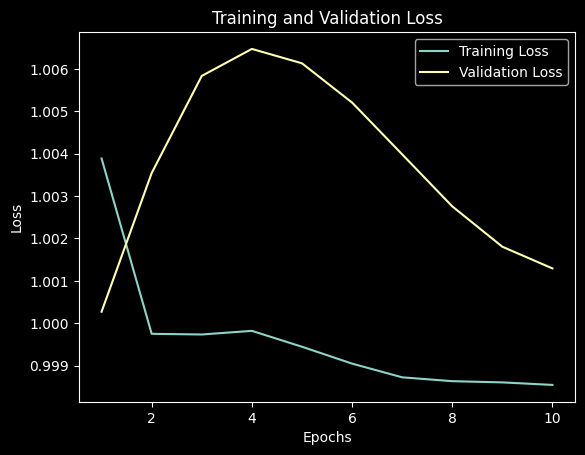

In [101]:
# Define the MLP model
model_MLP = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(1),
    ]
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_MLP.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
early_stopping_MLP = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True
)
history_MLP = model_MLP.fit(
    price_X_train_rolling,
    price_y_train_rolling,
    epochs=10,
    callbacks=[early_stopping_MLP],
    validation_data=(price_X_test_rolling, price_y_test_rolling),
    batch_size=len(price_X_train_rolling),  # Set batch size as the training set size
)

# Evaluate the model
y_pred_MLP_last = model_MLP.predict(price_X_last_rolling).reshape(-1)
y_pred_MLP_all = model_MLP.predict(price_X_all_rolling)
mse_MLP_train = mean_squared_error(price_y_train_rolling, 
                                   model_MLP.predict(price_X_train_rolling))
mse_MLP_test = mean_squared_error(price_y_test_rolling, 
                                   model_MLP.predict(price_X_test_rolling))

print(f"MLP MSE(train): {mse_MLP_train}")
print(f"MLP MSE(test): {mse_MLP_test}")
# MLP MSE(train): 0.9924953226659671
# MLP MSE(test): 0.9949950036401641

def Draw_Loss():
    # Extract loss values from the history object
    training_loss_MLP = history_MLP.history['loss']
    validation_loss_MLP = history_MLP.history['val_loss']

    # Create a range of epochs for x-axis
    epochs = range(1, len(training_loss_MLP) + 1)

    # Plot the training and validation loss values
    plt.figure()
    plt.plot(epochs, training_loss_MLP, label='Training Loss')
    plt.plot(epochs, validation_loss_MLP, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path_HS300_Rolling_pic + f'MLP_{backtest_date_index}.png')
    # plt.show()
Draw_Loss()

##### GBDT(XGboost)

In [102]:
params = {
    "learning_rate": 0.01,
    "max_depth": 64,
    "max_leaves": 512,
    "min_child_weight": 512,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:squarederror",
}

dtrain_rolling = xgb.DMatrix(price_X_train_rolling, label=price_y_train_rolling)
dtest_rolling = xgb.DMatrix(price_X_test_rolling, label=price_y_test_rolling)
dlast_rolling = xgb.DMatrix(price_X_last_rolling)
dall_rolling = xgb.DMatrix(price_X_all_rolling)

evals = [(dtest_rolling, "eval"), (dtrain_rolling, "train")]
num_round = 5

# train_loss_GBDT = []
# val_loss_GBDT = []
# Define a callback function to monitor the training progress and capture loss data
# def callback(env):
#     iteration = env.iteration
#     train_rmse = env.evaluation_result_list[1][1]
#     val_rmse = env.evaluation_result_list[0][1]
#     train_loss_GBDT.append(train_rmse)
#     val_loss_GBDT.append(val_rmse)

bst = xgb.train(
    params, 
    dtrain_rolling, 
    num_round, 
    evals, 
    early_stopping_rounds=50, 
    verbose_eval=True
)

y_pred_GBDT_last = bst.predict(dlast_rolling)
y_pred_GBDT_all = bst.predict(dall_rolling)
mse_GBDT_train = mean_squared_error(price_y_train_rolling, bst.predict(dtrain_rolling))
mse_GBDT_test = mean_squared_error(price_y_test_rolling, bst.predict(dtest_rolling))

print(f"GBDT MSE(train): {mse_GBDT_train}")
print(f"GBDT MSE(test): {mse_GBDT_test}")
# GBDT MSE(train): 0.9476405621114625
# GBDT MSE(test): 1.002617615102808

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-rmse:1.11577	train-rmse:1.11572
[1]	eval-rmse:1.11359	train-rmse:1.11341
[2]	eval-rmse:1.11143	train-rmse:1.11113
[3]	eval-rmse:1.10931	train-rmse:1.10890
[4]	eval-rmse:1.10721	train-rmse:1.10673
GBDT MSE(train): 1.2248522761097496
GBDT MSE(test): 1.2259124259750076


In [103]:
# plt.plot(train_rmse, label='Training RMSE')
# plt.plot(eval_rmse, label='Validation RMSE')
# plt.xlabel('epochs')
# plt.ylabel('RMSE')
# plt.title('Training and Validation RMSE')
# plt.legend()
# plt.show()

In [104]:
RAM_USAGE()

RAM Usage: 4727.73828125 MB


##### AGRU

##### Sequence preprocessing

In [105]:
from tqdm import tqdm  # For status process bar

# Create sequences of variable length for each stock
def create_sequences(df, sequence_length, begin_index, end_index, name):
    """
    sequence length: number of time steps in the entire sequence.
    In this paper, sequence length = 30.

    type: 'train' or 'test'

    begin index: index of the first sequence
    end index: index of the last sequence
    """
    sequences = []
    labels = []
    for stock in tqdm(df["ts_code"].unique(), desc=f"{name} Progress", ncols=100):
        # Single stock dataframe
        stock_df = df[df["ts_code"] == stock].reset_index(drop=True)
        for i in range(sequence_length + begin_index, end_index + 2):
            # The last sequence is included.
            seq = stock_df.iloc[i - sequence_length : i][
                [
                    "OPEN_processed",
                    "HIGH_processed",
                    "LOW_processed",
                    "CLOSE_processed",
                    "VWAP_processed",
                    "VOLUME_processed",
                ]
            ].values
            label = stock_df.iloc[i - 1]["Label_processed"]
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)


# Set the desired sequence length
sequence_length = 30

train_X, train_y = create_sequences(
    price_rolling, 
    sequence_length, 
    0, 
    len(date_train_rolling) - 1,
    'train'
)
# Note: len(date_train) + len(date_test) is the length of Modeling date.
test_X, test_y = create_sequences(
    price_rolling,
    sequence_length,
    len(date_train_rolling) - sequence_length + 1,
    len(date_train_rolling) + len(date_test_rolling) - 1,
    'test'
)
drop_X, _ = create_sequences(
    price_rolling,
    sequence_length,
    len(date_train_rolling) + len(date_test_rolling) - sequence_length + 1,
    len(date_all_rolling) - 1,
    'drop'
)
last_X, _ = create_sequences(
    price_rolling,
    sequence_length,
    len(date_all_rolling) - sequence_length,
    len(date_all_rolling) - 1,
    'last'
)

train Progress:   0%|                                                       | 0/239 [00:00<?, ?it/s]

last Progress: 100%|██████████████████████████████████████████████| 239/239 [00:04<00:00, 51.20it/s]


In [106]:
print(train_X.shape)
print(test_X.shape)
print(drop_X.shape)
print(last_X.shape)

(228006, 30, 6)
(56165, 30, 6)
(2629, 30, 6)
(239, 30, 6)


In [107]:
RAM_USAGE()

RAM Usage: 5002.40234375 MB


Epoch 1/5


2024-05-07 16:05:59.321416: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


761/761 [==============================] - ETA: 0s - loss: 1.0024

2024-05-07 16:06:26.956630: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


761/761 [==============================] - 32s 39ms/step - loss: 1.0024 - val_loss: 1.0029
Epoch 2/5
761/761 [==============================] - 28s 37ms/step - loss: 0.9989 - val_loss: 1.0024
Epoch 3/5
761/761 [==============================] - 28s 37ms/step - loss: 0.9987 - val_loss: 1.0011
Epoch 4/5
761/761 [==============================] - 28s 37ms/step - loss: 0.9986 - val_loss: 1.0010
Epoch 5/5
1756/1756 [==============================] - 12s 7ms/step - loss: 1.0022
Model trained with loss: 1.002171516418457
   1/7126 [..............................] - ETA: 1:01:24

2024-05-07 16:08:33.884306: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


8/8 [==============================] - 0s 6ms/step
AGRU MSE(train): 0.9985156784274409
AGRU MSE(test): 1.0021715021357893


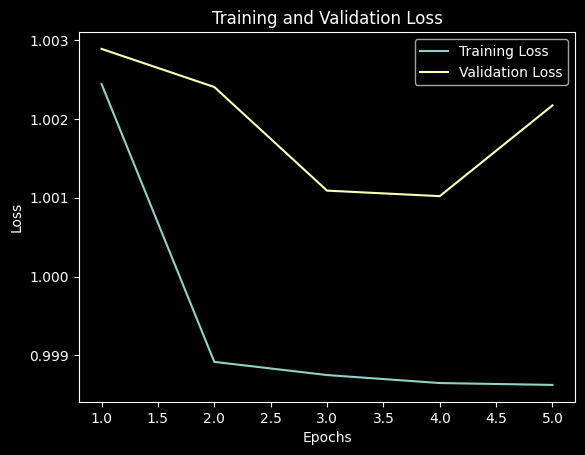

In [108]:
# Define the AGRU model
inputs = Input(shape=(30, 6))
gru = GRU(units=6, return_sequences=True)(inputs)
att = Attention()([gru, gru])
gru = GRU(units=6)(att)
outputs = Dense(1)(gru)

model_AGRU = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_AGRU.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")

# Define early stopping criteria
early_stopping_AGRU = EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)

# Train the model
history_AGRU = model_AGRU.fit(
    train_X,
    train_y,
    epochs=5,
    batch_size=batch_size,
    validation_data=(test_X, test_y),
    callbacks=[early_stopping_AGRU],
)

# Evaluate the model
loss = model_AGRU.evaluate(test_X, test_y)
print("Model trained with loss:", loss)

# Evaluate the model on test data
y_pred_AGRU_train = model_AGRU.predict(train_X)
y_pred_AGRU_test = model_AGRU.predict(test_X)
y_pred_AGRU_drop = model_AGRU.predict(drop_X)
y_pred_AGRU_last = model_AGRU.predict(last_X).reshape(-1)
# y_pred_AGRU_backtest = np.concatenate(
#     (y_pred_AGRU_test.reshape(-1), 
#      y_pred_AGRU_drop.reshape(-1))
# )
# y_pred_AGRU_backtest = y_pred_AGRU_backtest
y_pred_AGRU_all = np.concatenate((np.concatenate((y_pred_AGRU_train.reshape(-1), 
                                                  y_pred_AGRU_test.reshape(-1))),
                                                  y_pred_AGRU_drop.reshape(-1)))
mse_AGRU_train = mean_squared_error(train_y, y_pred_AGRU_train)
mse_AGRU_test = mean_squared_error(test_y, y_pred_AGRU_test)
print(f"AGRU MSE(train): {mse_AGRU_train}")
print(f"AGRU MSE(test): {mse_AGRU_test}")
# AGRU MSE(train): 0.9896615693578518
# AGRU MSE(test): 0.9960141348406323

def Draw_Loss():
    # Extract loss values from the history object
    training_loss_AGRU = history_AGRU.history['loss']
    validation_loss_AGRU = history_AGRU.history['val_loss']

    # Create a range of epochs for x-axis
    epochs = range(1, len(training_loss_AGRU) + 1)

    # Plot the training and validation loss values
    plt.figure()
    plt.plot(epochs, training_loss_AGRU, label='Training Loss')
    plt.plot(epochs, validation_loss_AGRU, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path_HS300_Rolling_pic + f'AGRU_{backtest_date_index}.png')
    # plt.show()
Draw_Loss()

In [109]:
RAM_USAGE()

RAM Usage: 5355.44921875 MB


##### Ensemble

In [110]:
def Create_Factor_all(y_pred_all):
    # This is for y_pred_all.
    factor_df = price_rolling[["trade_date", "ts_code"]]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_all  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_Factor_backtest(y_pred_backtest):
    # This is for y_pred_all.
    factor_df = price_rolling.loc[
        price_rolling["trade_date"].isin(date_last_rolling), :
        ][["trade_date", "ts_code"]]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_backtest  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_ICIR_df(factor_DF):
    # This is for y_pred_all.
    IC_series = factor_DF.corrwith(price_return_rolling, axis=1, method="spearman")
    ICIR_df = IC_series.shift(1).rolling(60).apply(lambda x: x.mean() / x.std())
    ICIR_df = ICIR_df[
        ICIR_df.index.isin(date_last_rolling)
    ]  # Select the ICIR in the test date.
    return ICIR_df

In [111]:
MLP_factor_all = Create_Factor_all(y_pred_MLP_all)
MLP_factor_backtest = Create_Factor_backtest(y_pred_MLP_last)
GBDT_factor_all = Create_Factor_all(y_pred_GBDT_all)
GBDT_factor_backtest = Create_Factor_backtest(y_pred_GBDT_last)

AGRU_factor_all = price_rolling.loc[
    price_rolling["trade_date"].isin(date_GRU_rolling), :
    ].reset_index(drop=True)
AGRU_factor_all = AGRU_factor_all[["trade_date", "ts_code"]]  # Date and stock
AGRU_factor_all.loc[:, "AGRU"] = y_pred_AGRU_all  # Add factor values
AGRU_factor_all = AGRU_factor_all.pivot(
    index="trade_date", columns="ts_code", values="AGRU"
)  # Transfer to factor dataframe
AGRU_factor_backtest = Create_Factor_backtest(y_pred_AGRU_last)

# Use abs()
MLP_ICIR = Create_ICIR_df(MLP_factor_all)
MLP_ICIR = MLP_ICIR.abs()

GBDT_ICIR = Create_ICIR_df(GBDT_factor_all)
GBDT_ICIR = GBDT_ICIR.abs()

AGRU_ICIR = Create_ICIR_df(AGRU_factor_all)
AGRU_ICIR = AGRU_ICIR.abs()

In [112]:
# Ensembling
def Ensemble_ICIR_weight():
    # Ensemble the models based on ICIR weight
    SUM_ICIR = MLP_ICIR + GBDT_ICIR + AGRU_ICIR
    MLP_ratio = MLP_ICIR / SUM_ICIR
    GBDT_ratio = GBDT_ICIR / SUM_ICIR
    AGRU_ratio = AGRU_ICIR / SUM_ICIR

    MLP_weight = MLP_factor_backtest.multiply(MLP_ratio, axis=0)
    GBDT_weight = GBDT_factor_backtest.multiply(GBDT_ratio, axis=0)
    AGRU_weight = AGRU_factor_backtest.multiply(AGRU_ratio, axis=0)

    ICIR_weight = MLP_weight + GBDT_weight + AGRU_weight
    return ICIR_weight
def Ensemble_ICIR_max(*ICIR_df, type_list):
    # Ensemble the models based on max ICIR

    # Concatenate ICIR DataFrames into Combine_df
    # for ICIR in ICIR_df:
    #     Combine_df = pd.concat([Combine_df, ICIR], axis=1)
    Combine_df = pd.concat(ICIR_df, axis=1)
    Combine_df.columns = type_list
    # print(Combine_df)
    Combine_ranks = Combine_df.rank(axis=1, ascending=False)

    # Choose max ICIR and assign it as 1, others as 0
    Keep_df = Combine_ranks.applymap(lambda x: 1 if x == 1 else 0)

    Ensemble_max = pd.DataFrame()
    for TYPE in type_list:
        # Dynamically create variable names using exec()
        keepp = Keep_df[TYPE]
        # Find factor df use globals()
        positionn = globals()[f"{TYPE}_factor_backtest"].where(keepp == 1, 0)
        Ensemble_max = Ensemble_max.add(positionn, fill_value=0)
    return Ensemble_max

In [113]:
Ensemble_max_factor_df = Ensemble_ICIR_max(MLP_ICIR, GBDT_ICIR, AGRU_ICIR,
                                           type_list=["MLP", "GBDT", "AGRU"])

In [114]:
Ensemble_max_factor_df

ts_code,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,...,603288.SH,603369.SH,603501.SH,603659.SH,603799.SH,603806.SH,603833.SH,603899.SH,603986.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-01-20,-0.033516,-0.025755,-0.016608,-0.00871,-0.039734,0.006482,-0.039747,-0.031275,0.03921,0.005992,...,0.027586,0.047505,0.018449,0.042786,0.022073,0.034349,0.038379,0.054162,0.022823,-0.039289


In [115]:
Ensemble_max_factor_df_Monday = Ensemble_max_factor_df.copy()
Ensemble_max_factor_df_Monday.index = date_backtest_rolling_Monday
Ensemble_max_factor_df_Monday = Ensemble_max_factor_df_Monday.rename_axis(index='trade_date')
Ensemble_max_factor_df_Monday

ts_code,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,...,603288.SH,603369.SH,603501.SH,603659.SH,603799.SH,603806.SH,603833.SH,603899.SH,603986.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-01-30,-0.033516,-0.025755,-0.016608,-0.00871,-0.039734,0.006482,-0.039747,-0.031275,0.03921,0.005992,...,0.027586,0.047505,0.018449,0.042786,0.022073,0.034349,0.038379,0.054162,0.022823,-0.039289


In [116]:
Ensemble_weight_factor_df = Ensemble_ICIR_weight()

In [117]:
Ensemble_weight_factor_df_Monday = Ensemble_weight_factor_df.copy()
Ensemble_weight_factor_df_Monday.index = date_backtest_rolling_Monday
Ensemble_weight_factor_df_Monday = Ensemble_weight_factor_df_Monday.rename_axis(index='trade_date')
Ensemble_weight_factor_df_Monday

ts_code,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,...,603288.SH,603369.SH,603501.SH,603659.SH,603799.SH,603806.SH,603833.SH,603899.SH,603986.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-01-30,0.197621,0.200727,0.210251,0.21132,0.193935,0.219883,0.192274,0.201049,0.239942,0.219086,...,0.228113,0.244269,0.226949,0.241766,0.23178,0.233107,0.234079,0.244531,0.225972,0.195012


### Back testing

In [118]:
# Split return rates data
price_return_backtest = price_return.loc[price_return.index.isin(date_backtest), :]
benchmark_return_backtest = benchmark_return.loc[
    benchmark_return.index.isin(date_backtest), :
]
HS_300_backtest = HS_300.loc[HS_300.index.isin(date_backtest), :]["000300.SH"]
CS_500_backtest = CS_500.loc[HS_300.index.isin(date_backtest), :]["000905.SH"]
CS_1000_backtest = CS_1000.loc[HS_300.index.isin(date_backtest), :]["000852.SH"]

price_backtest = price.loc[price["trade_date"].isin(date_backtest), :]
price_X_backtest = price_backtest[X_indexes].values
price_y_backtest = price_backtest[y_index].values

NameError: name 'benchmark_return' is not defined

In [ ]:
def Ensure_position(DF):
    # We add a column named 'Monday' and change positions every Monday.
    DF = DF.shift(1)  # Move one step forward to ensure position
    DF["Monday"] = (DF.index.dayofweek == 0).astype(int)  # Shift except Monday

    # Get the columns to shift (all columns except 'Monday')
    cols_to_shift = DF.columns[DF.columns != "Monday"]

    DF.loc[DF["Monday"] == 0, cols_to_shift] = np.nan
    DF.fillna(
        method="ffill", inplace=True
    )  # Forward fill, holing positions for a week.
    DF.fillna(value=0, inplace=True)  # Fill remaining NaN with 0
    return DF

def Layer_Backtest(factor_df, type, num_layers = 20):
    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)
    layer_allocation

    # import matplotlib.cm as cm

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")

    # Define a color map to use for changing colors progressively
    # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

    global profit_long, profit_short
    profit_long = profit_short = None

    def Long_Short(Num_layers, Layer, Profit):
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # The short profit comes from the decline of the stock.
            profit_short = profit_short.apply(
                lambda x: x + 1 if x == 0 else -x + (1 - 0.0003))
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(
                lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    Long_position_df = None
    for layer in range(0, num_layers):
        # Ensure holding stocks
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(
            layer_allocation == layer, 1)
        hold_flag_matrix = Ensure_position(hold_flag_matrix)
        if layer == num_layers - 1:
            Long_position_df = hold_flag_matrix.copy()

        # Delete 'Monday' to fit into yield dataframe.
        del hold_flag_matrix["Monday"]

        # Calculate the sum of each line in turn.
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = hold_flag_matrix.apply(
            lambda x: x / stock_amount_sum, axis=0
        ).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        # Create Long and Short position
        Long_Short(num_layers, layer, profit)

        # Calculate the daily equity and draw.
        # Using the 'viridis' colormap with a gradient based on layer number
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    (profit_long + profit_short).plot(color="orange", label="long_short", legend=True)
    plt.title(f"20-Layered Portfolio Equity ({type})")
    plt.legend(title="Layer", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

    return profit_long, Long_position_df

In [ ]:
def Layer_Backtest(factor_df, TYPE):
    # layer number
    num_layers = 20

    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)
    layer_allocation

    # import matplotlib.cm as cm

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")

    # Define a color map to use for changing colors progressively
    # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

    global profit_long, profit_short
    profit_long = profit_short = None

    def Long_Short(Num_layers, Layer, Profit):
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # The short profit comes from the decline of the stock.
            profit_short = profit_short.apply(
                lambda x: x + 1 if x == 0 else -x + (1 - 0.0003)
            )
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(
                lambda x: x + 1 if x == 0 else x + (1 - 0.0003)
            )
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    Long_position_df = None
    for layer in range(0, num_layers):
        # Ensure holding stocks
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(
            layer_allocation == layer, 1
        )
        hold_flag_matrix = Ensure_position(hold_flag_matrix)
        if layer == num_layers - 1:
            Long_position_df = hold_flag_matrix.copy()

        # Delete 'Monday' to fit into yield dataframe.
        del hold_flag_matrix["Monday"]

        # Calculate the sum of each line in turn.
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = hold_flag_matrix.apply(
            lambda x: x / stock_amount_sum, axis=0
        ).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        # Create Long and Short position
        Long_Short(num_layers, layer, profit)

        # Calculate the daily equity and draw.
        # Using the 'viridis' colormap with a gradient based on layer number
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    (profit_long + profit_short).plot(color="orange", label="long_short", legend=True)
    plt.title(f"20-Layered Portfolio Equity ({TYPE})")
    plt.legend(title="Layer", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

    return profit_long, Long_position_df

### Ensemble Backtest

In [ ]:
# Ensemble_factor_df_a = Ensemble_factor_df[Ensemble_factor_df.index >= "2023-07-01"]

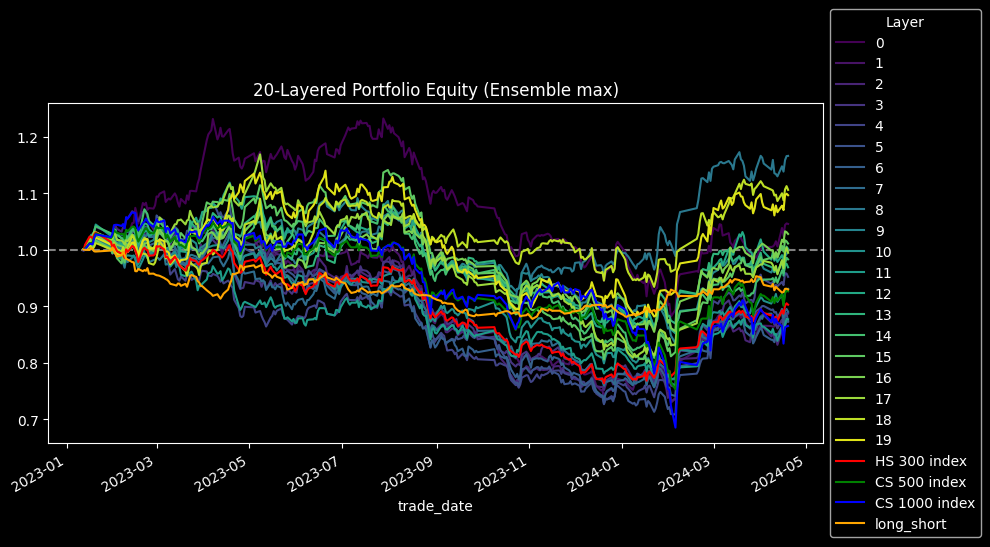

In [ ]:
profit_long_Ensemble_max, \
Long_position_df_Ensemble_max = Layer_Backtest(Ensemble_max_factor_df, "Ensemble max")

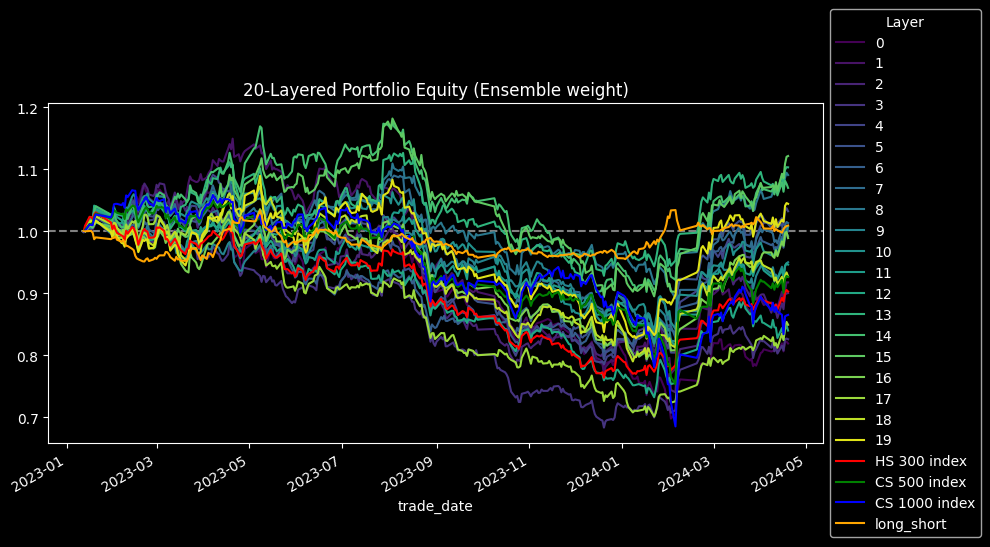

In [ ]:
profit_long_Ensemble_weight, \
Long_position_df_Ensemble_weight = Layer_Backtest(Ensemble_weight_factor_df, "Ensemble weight")

In [ ]:
Long_position_df_Ensemble_weight.to_csv("Long_position_df_Ensemble_weight.csv")

### MLP Backtest

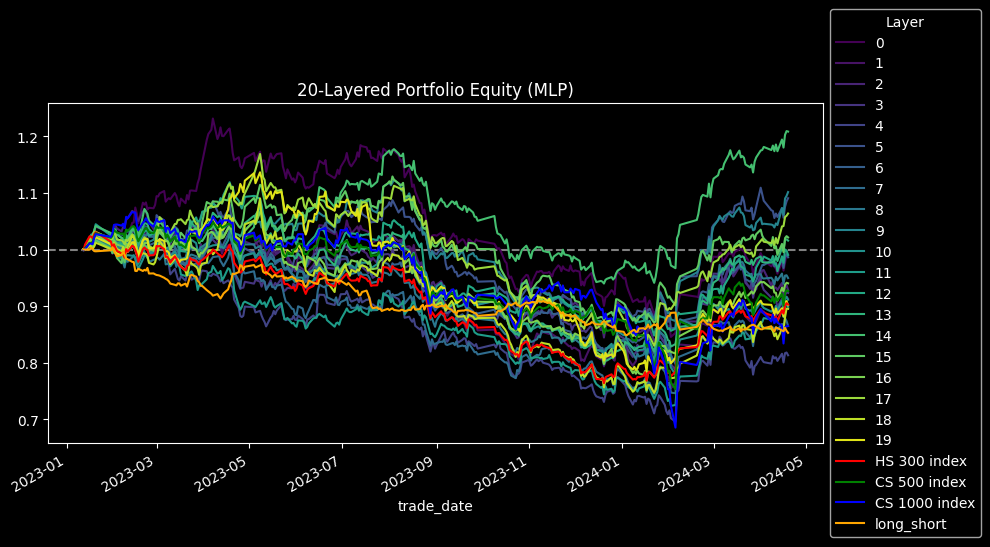

In [ ]:
profit_long_MLP, Long_position_df_MLP = Layer_Backtest(MLP_factor_backtest, "MLP")

### GBDT Backtest

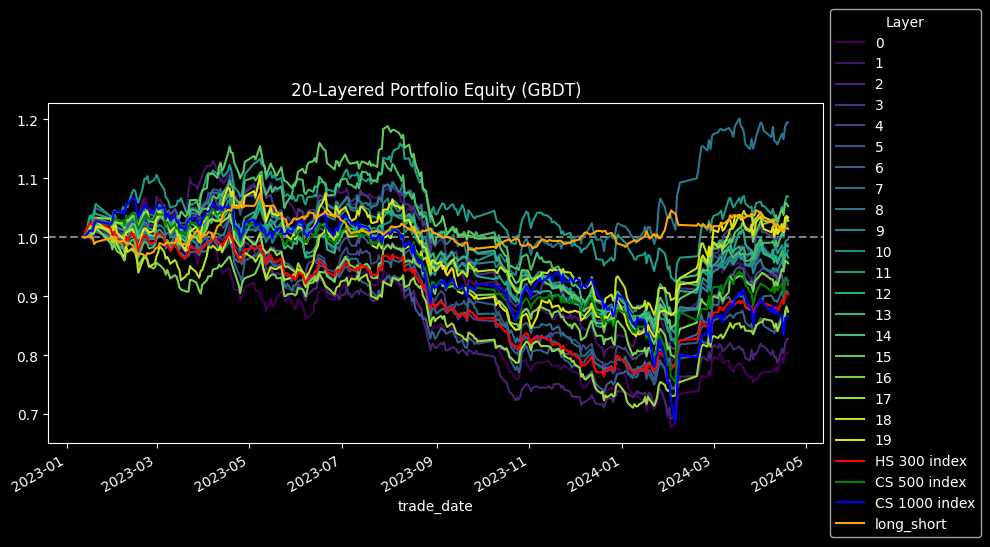

In [ ]:
profit_long_GBDT, Long_position_df_GBDT = Layer_Backtest(GBDT_factor_backtest, "GBDT")

### AGRU Backtest

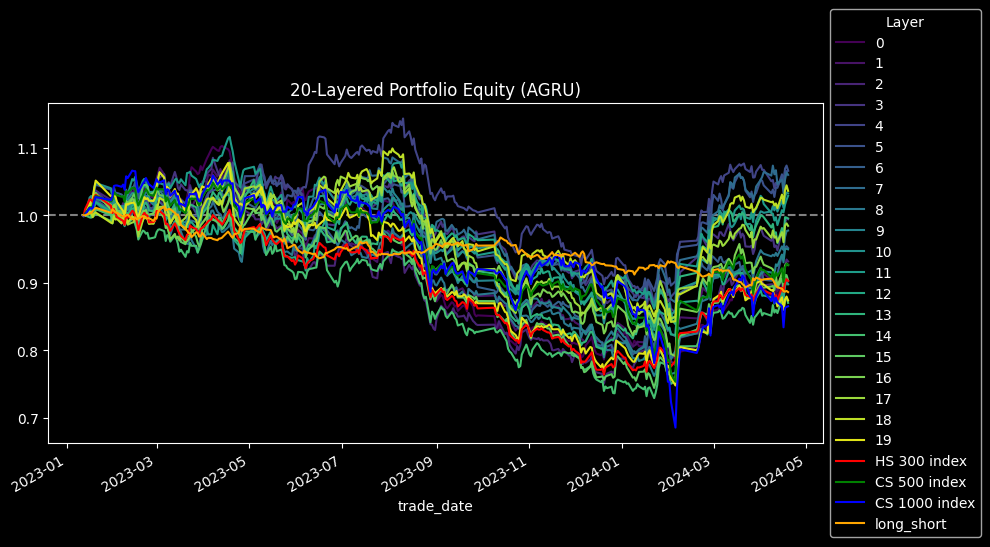

In [ ]:
profit_long_AGRU, Long_position_df_AGRU = Layer_Backtest(AGRU_factor_backtest, "AGRU")

### Ensure future position

In [ ]:
def Ensure_Future_position_all(factor_df, layer, num_layers = 20):
    last_day = factor_df.iloc[-1, :]
    # Calculte the ranks of factors daily.
    factor_ranks = last_day.rank(ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(last_day) / num_layers)).fillna(0)

    selected_stocks = list(layer_allocation[layer_allocation == layer].index)
    return selected_stocks

selected_stocks_main = Ensure_Future_position_all(Ensemble_weight_factor_df, 19)
# In this condition, the long position is in layer 19.
selected_stocks_main

['002475.SZ',
 '300450.SZ',
 '600011.SH',
 '600036.SH',
 '600150.SH',
 '600362.SH',
 '600547.SH',
 '601169.SH',
 '601318.SH',
 '601939.SH',
 '603019.SH']

In [ ]:
all_stocks[all_stocks['ts_code'].isin(selected_stocks_main)]

,ts_code,symbol,name,area,industry,fullname,enname,cnspell,market,exchange,curr_type,list_status,list_date,delist_date,is_hs,act_name,act_ent_type
1071,002475.SZ,002475,立讯精密,深圳,元器件,立讯精密工业股份有限公司,"Luxshare Precision Industry Co.,Ltd.",lxjm,主板,SZSE,CNY,L,20100915,None,S,王来春,外资企业
2060,300450.SZ,300450,先导智能,江苏,专用机械,无锡先导智能装备股份有限公司,"Wuxi Lead Intelligent Equipment Co.,Ltd.",xdzn,创业板,SZSE,CNY,L,20150518,None,S,None,None
3009,600011.SH,600011,华能国际,北京,火力发电,华能国际电力股份有限公司,"Huaneng Power International,Inc.",hngj,主板,SSE,CNY,L,20011206,None,H,None,None
3030,600036.SH,600036,招商银行,深圳,银行,招商银行股份有限公司,"China Merchants Bank Co., Ltd.",zsyh,主板,SSE,CNY,L,20020409,None,H,None,None
3129,600150.SH,600150,中国船舶,上海,船舶,中国船舶工业股份有限公司,China CSSC Holdings Limited,zgcb,主板,SSE,CNY,L,19980520,None,H,None,None
3319,600362.SH,600362,江西铜业,江西,铜,江西铜业股份有限公司,Jiangxi Copper Company Limited,jxty,主板,SSE,CNY,L,20020111,None,H,江西省国有资产监督管理委员会,地方国企
3460,600547.SH,600547,山东黄金,山东,黄金,山东黄金矿业股份有限公司,"Shandong Gold Mining Co.,Ltd.",sdhj,主板,SSE,CNY,L,20030828,None,H,None,None
3934,601169.SH,601169,北京银行,北京,银行,北京银行股份有限公司,"Bank of Beijing Co., Ltd.",bjyh,主板,SSE,CNY,L,20070919,None,H,None,None
3964,601318.SH,601318,中国平安,深圳,保险,中国平安保险(集团)股份有限公司,"Ping An Insurance (Group) Company of China, Ltd.",zgpa,主板,SSE,CNY,L,20070301,None,H,None,None
4078,601939.SH,601939,建设银行,北京,银行,中国建设银行股份有限公司,China Construction Bank Corporation,jsyh,主板,SSE,CNY,L,20070925,None,H,None,None


### Simple Backtest
(Small number of stocks)

In [ ]:
def Simple_Backtest(factor_df, stock_num, Ascending):
    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=Ascending)

    # Create position_df based on top 3 ranks
    position_df = factor_ranks.apply(lambda x: x <= stock_num).astype(int)
    position_df = Ensure_position(position_df)

    # Delete 'Monday' to fit into yield dataframe.
    del position_df["Monday"]

    # Calculate the sum of each line in turn.
    stock_amount_sum = position_df.sum(axis=1)

    # Calculate the weight of each stock. (Average distribution at the same level)
    weight_allocation = position_df.apply(
        lambda x: x / stock_amount_sum, axis=0
    ).fillna(0)

    # Calculate the daily profit rate. And prepare to calculate cumprod.
    profit = (weight_allocation * price_return_backtest).sum(axis=1)

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")
    # Calculate the daily equity and draw.
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label="Stocks", legend=True, color="#800080")

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    plt.title(f"Equity of {stock_num} stocks")
    plt.legend(title="Index", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

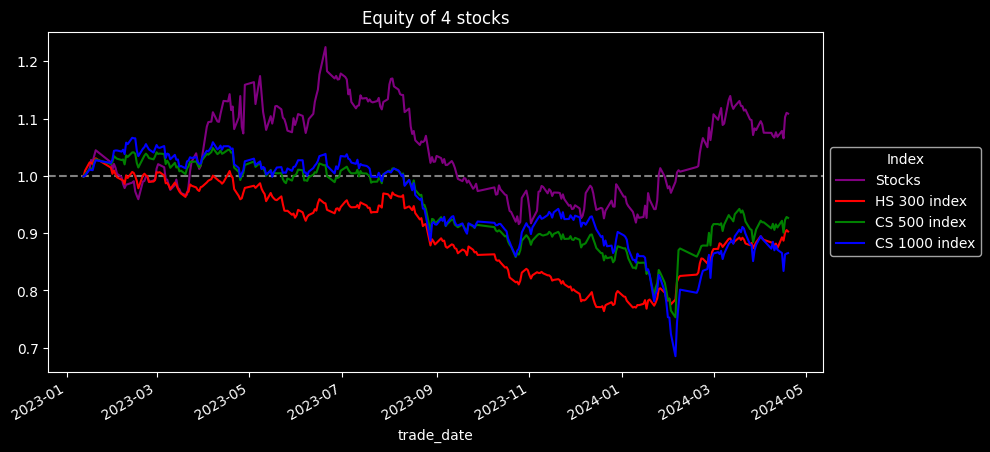

In [ ]:
Simple_Backtest(Ensemble_weight_factor_df, 4, True)

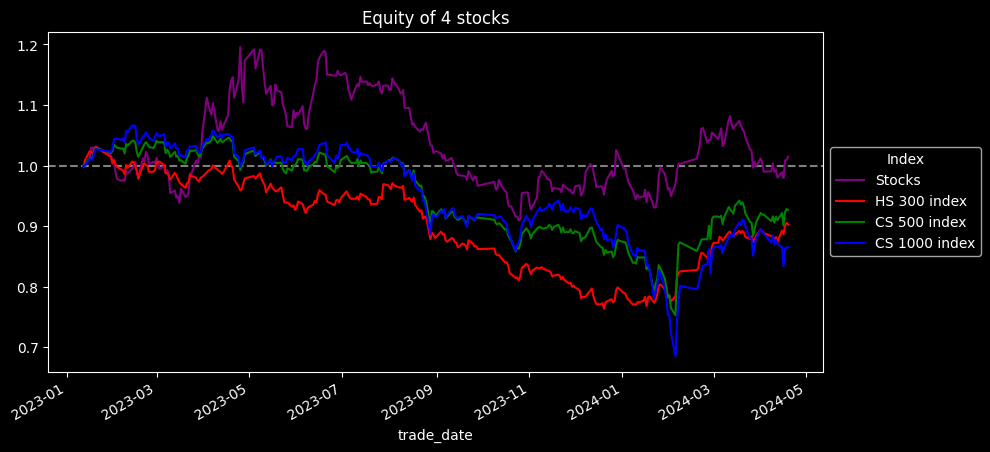

In [ ]:
Simple_Backtest(Ensemble_max_factor_df, 4, True)

In [ ]:
def Ensure_Future_position_small(factor_df, stock_num, Ascending):
    last_day = factor_df.iloc[-1, :]

    # Calculte the ranks of factors daily.
    factor_ranks = last_day.rank(ascending=Ascending)

    # Create a boolean mask to identify columns where values are between 0 and stock_num - 1
    mask = (factor_ranks > 0) & (factor_ranks <= stock_num)
    print(factor_ranks[mask].sort_values())
    selected_stocks = list(factor_ranks[mask].sort_values().index)
    return selected_stocks

Selected_Stocks = Ensure_Future_position_small(Ensemble_weight_factor_df, 6, True)
Selected_Stocks

ts_code
601888.SH    1.0
601939.SH    2.0
600150.SH    3.0
600547.SH    4.0
600011.SH    5.0
002475.SZ    6.0
Name: 2024-04-19 00:00:00, dtype: float64


['601888.SH', '601939.SH', '600150.SH', '600547.SH', '600011.SH', '002475.SZ']

In [ ]:
Trade_Stock_Close_Dict = dict(price.pivot(index="trade_date", 
                                          columns="ts_code", 
                                          values="CLOSE")[Selected_Stocks].iloc[-1, :])
Trade_Stock_Close_Dict

{'601888.SH': 72.35,
 '601939.SH': 7.35,
 '600150.SH': 39.1,
 '600547.SH': 31.43,
 '600011.SH': 9.57,
 '002475.SZ': 26.39}

In [ ]:
# Plan A: Buy at open and sell at close
# Plan B:
def Real_trading(Stock_Price_dict, Money, slippage):
    """
    Stamp_duty = 0.0005 (Sell)
    Transfer_fee = 0.00001 (Buy + Sell)
    Commission = 0.00025 (Buy + Sell)(Commission > 5)
    """
    Stock_codes = list(Stock_Price_dict.keys())
    Average_Capital = Money / len(Stock_codes)
    print("Initial Average Capital:", Average_Capital)
    reduce_hand = 0
    position_dict = dict()
    while(1):
        All = 0
        for stock in Stock_codes:
            price = Stock_Price_dict[stock] + slippage
            hands = Average_Capital // (price * 100) - reduce_hand
            Initial = hands * price * 100
            Transfer_fee = Initial * 0.00001
            Commission = Initial * 0.00025 if Initial * 0.00025 >= 5 else 5
            total = Initial + Transfer_fee + Commission
            position_dict[stock] = f"price: {price}, total: {total}, hands: {hands}, fee: {Transfer_fee+Commission}"
            All += Initial + Transfer_fee + Commission
        if All > Money:
            reduce_hand += 1
        else:
            print(f"All init money: {Money}")
            print(f"All position money: {All}")
            break
    return position_dict

In [ ]:
Real_trading(Trade_Stock_Close_Dict, 45018303.82, 0)

Initial Average Capital: 7503050.636666667
All init money: 45018303.82
All position money: 45005932.50084


{'601888.SH': 'price: 72.35, total: 7497408.819599999, hands: 1036.0, fee: 1948.8195999999998',
 '601939.SH': 'price: 7.35, total: 7504095.5577, hands: 10207.0, fee: 1950.5577',
 '600150.SH': 'price: 39.1, total: 7497418.822199999, hands: 1917.0, fee: 1948.8222',
 '600547.SH': 'price: 31.43, total: 7501147.79148, hands: 2386.0, fee: 1949.79148',
 '600011.SH': 'price: 9.57, total: 7503873.49998, hands: 7839.0, fee: 1950.49998',
 '002475.SZ': 'price: 26.39, total: 7501988.00988, hands: 2842.0, fee: 1950.00988'}

In [ ]:
all_stocks[all_stocks['ts_code'].isin(Selected_Stocks)].set_index('ts_code').reindex(Selected_Stocks).reset_index()

,ts_code,symbol,name,area,industry,fullname,enname,cnspell,market,exchange,curr_type,list_status,list_date,delist_date,is_hs,act_name,act_ent_type
0,601888.SH,601888,中国中免,北京,旅游服务,中国旅游集团中免股份有限公司,China Tourism Group Duty Free Corporation Limited,zgzm,主板,SSE,CNY,L,20091015,None,H,None,None
1,601939.SH,601939,建设银行,北京,银行,中国建设银行股份有限公司,China Construction Bank Corporation,jsyh,主板,SSE,CNY,L,20070925,None,H,None,None
2,600150.SH,600150,中国船舶,上海,船舶,中国船舶工业股份有限公司,China CSSC Holdings Limited,zgcb,主板,SSE,CNY,L,19980520,None,H,None,None
3,600547.SH,600547,山东黄金,山东,黄金,山东黄金矿业股份有限公司,"Shandong Gold Mining Co.,Ltd.",sdhj,主板,SSE,CNY,L,20030828,None,H,None,None
4,600011.SH,600011,华能国际,北京,火力发电,华能国际电力股份有限公司,"Huaneng Power International,Inc.",hngj,主板,SSE,CNY,L,20011206,None,H,None,None
5,002475.SZ,002475,立讯精密,深圳,元器件,立讯精密工业股份有限公司,"Luxshare Precision Industry Co.,Ltd.",lxjm,主板,SZSE,CNY,L,20100915,None,S,王来春,外资企业


In [ ]:
def execute_trade(stock_data, initial_capital, tickers):
    portfolio = {ticker: {'Position': 0, 'Value': 0, 'Shares': 0} for ticker in tickers}
    
    for ticker in tickers:
        for i in range(len(stock_data)):
            price = stock_data.loc[i, 'Close']
            signal = stock_data.loc[i, 'Signal']
            
            if signal == 1 and portfolio[ticker]['Position'] == 0:
                available_capital = initial_capital - sum([v['Value'] for v in portfolio.values()])
                shares_to_buy = available_capital // price
                portfolio[ticker]['Position'] = 1
                portfolio[ticker]['Value'] = shares_to_buy * price
                portfolio[ticker]['Shares'] = shares_to_buy
                initial_capital -= portfolio[ticker]['Value']
            
            elif signal == 0 and portfolio[ticker]['Position'] == 1:
                initial_capital += portfolio[ticker]['Value']
                portfolio[ticker]['Position'] = 0
                portfolio[ticker]['Value'] = 0
                portfolio[ticker]['Shares'] = 0
                
    return portfolio

### Indexes

1. RankIC mean(IC mean)
2. ICIR
3. IC winning rate
4. IC t-value
5. Long ROI
6. Long sharp
7. Long retracement
8. Long average weekly turnover rate

In [ ]:
def Backtest_Indexes(factor_df, Profit_Long):
    # ICIR
    IC_series = factor_df.corrwith(price_return_backtest, axis=1, method="spearman")
    IC_mean = IC_series.mean()
    print(f"IC mean: {IC_mean}")
    ICIR = IC_series.mean() / IC_series.std()
    print(f"ICIR: {ICIR}")
    IC_series.hist(bins=30)

    # RankIC
    # Create a figure and axis
    _, ax = plt.subplots(figsize=(8, 4))
    # Plot histogram of values on the left side
    ax.bar(IC_series.index, IC_series.values)
    ax.set_title('Histogram of Series Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('RankIC')
    # Create a twin Axes sharing the xaxis
    ax2 = ax.twinx()
    # Plot cumulative line on the right side
    ax2.plot(IC_series.index, IC_series.cumsum(), color='orange')
    ax2.set_ylabel('Cumulative Sum')
    
    # IC winning rate
    IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
    print(f"IC winning rate: {IC_winning_rate}")

    t_value = ICIR / sqrt(len(IC_series))
    print(f"IC t-value: {t_value}")

    # Long (Except Short), so `profit_long * 2`
    # profit_long is long equity series.
    Long_equity = Profit_Long * 2
    Long_ROI = (Long_equity[-1]) - 1
    print(f"Long ROI: {Long_ROI}")

    # Max Drawdown
    # Calculate the previous peaks
    previous_peaks = Long_equity.cummax()
    # Calculate the drawdowns
    drawdowns = (Long_equity - previous_peaks) / previous_peaks

    # Find the maximum drawdown and the dates associated with it
    # Convert the index labels to a numeric format
    drawdowns.index = pd.to_numeric(drawdowns.index)
    max_drawdown = drawdowns.min()
    print(f"Max drawdown: {max_drawdown}")
    max_drawdown_start = drawdowns.idxmin()

    # Convert the start and end dates back to the original format if needed
    max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
    print(f"Max drawdown begin date: {max_drawdown_start}")

    plt.show()

IC mean: -0.06298870008043647
ICIR: -0.5291484129312862
IC winning rate: 0.2875816993464052
IC t-value: -0.03024940138270654
Long ROI: 0.09665446624401275
Max drawdown: -0.22735403231364917
Max drawdown begin date: 2024-01-17


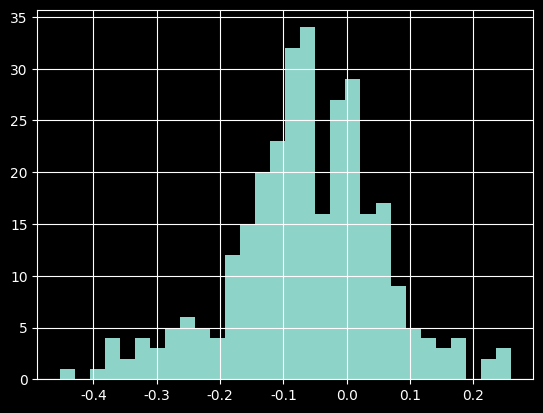

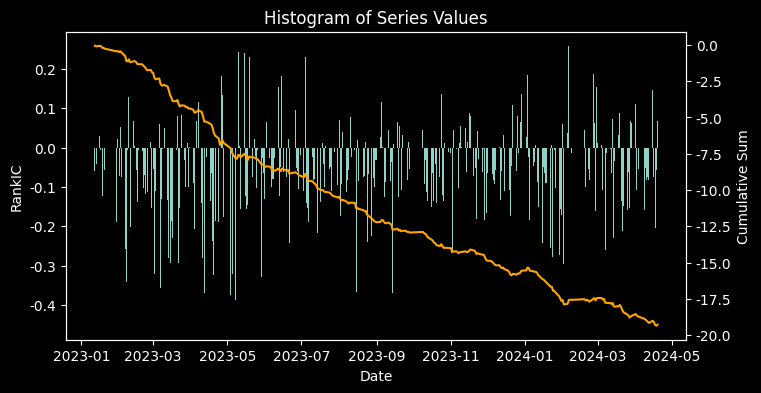

In [ ]:
Backtest_Indexes(Ensemble_max_factor_df, profit_long_Ensemble_max)

IC mean: -0.06450588944199831
ICIR: -0.5036355972126518
IC winning rate: 0.3006535947712418
IC t-value: -0.028790930783124086
Long ROI: 0.04430302056448254
Max drawdown: -0.24109909666944238
Max drawdown begin date: 2024-01-17


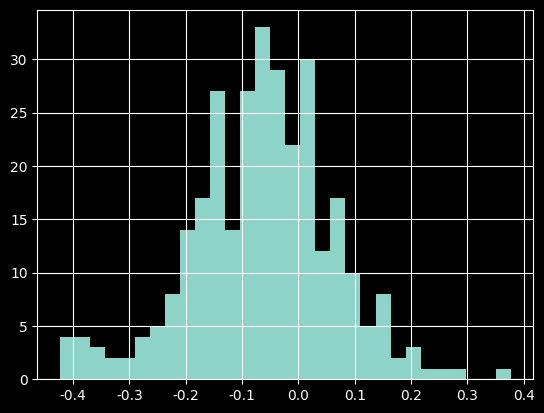

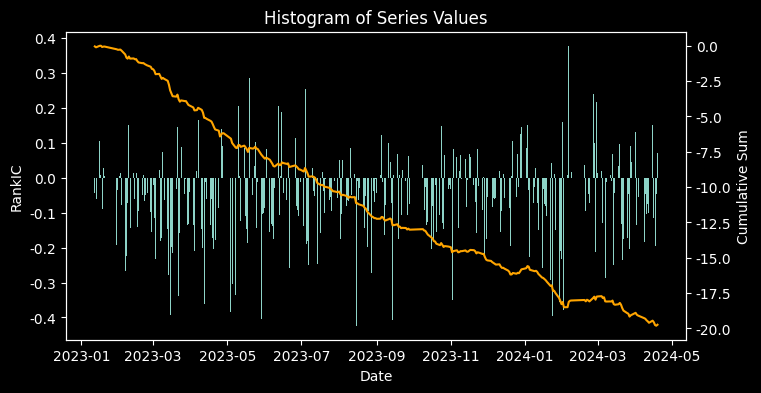

In [ ]:
Backtest_Indexes(Ensemble_weight_factor_df, profit_long_Ensemble_weight)

IC mean: -0.06414098959716828
ICIR: -0.3985407400702251
IC winning rate: 0.34967320261437906
IC t-value: -0.02278305768123066
Long ROI: -0.0985075962134292
Max drawdown: -0.3103467882192779
Max drawdown begin date: 2024-01-17


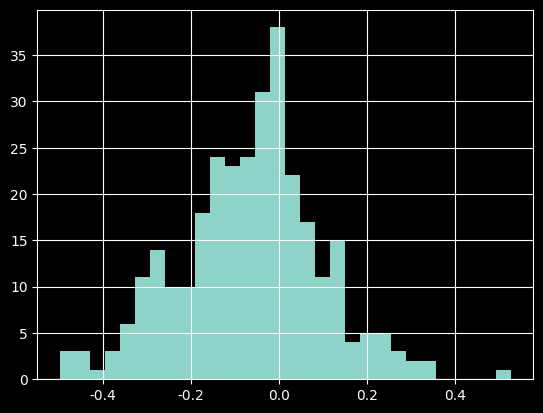

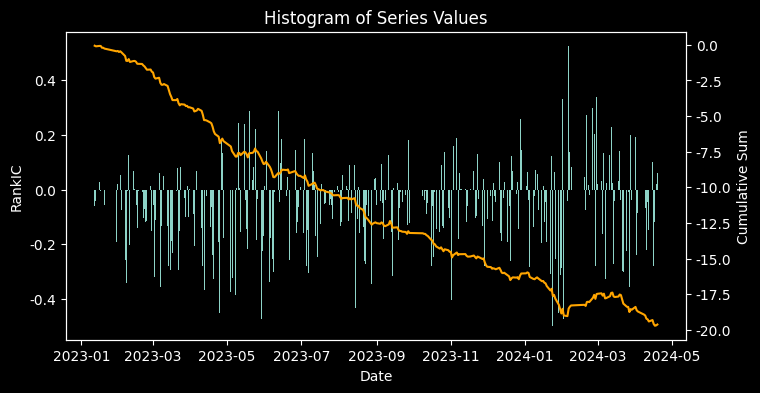

In [ ]:
Backtest_Indexes(MLP_factor_backtest, profit_long_MLP)

IC mean: -0.056824069214176084
ICIR: -0.5295486000789936
IC winning rate: 0.2908496732026144
IC t-value: -0.030272278559247884
Long ROI: 0.03364691249969454
Max drawdown: -0.2484770332119807
Max drawdown begin date: 2024-01-17


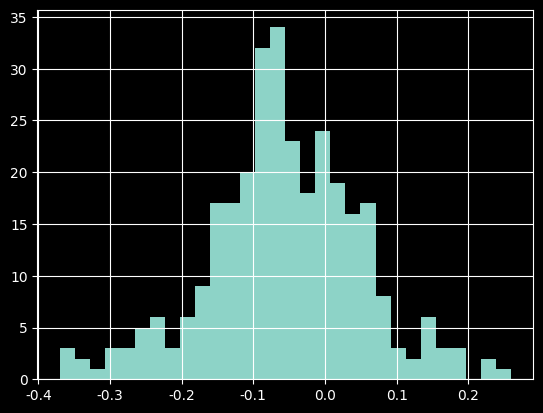

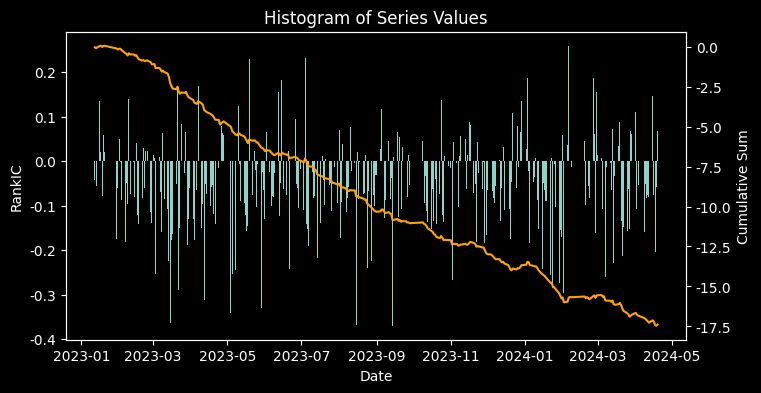

In [ ]:
Backtest_Indexes(GBDT_factor_backtest, profit_long_GBDT)

IC mean: 0.003137827259989859
ICIR: 0.047331911694700864
IC winning rate: 0.5098039215686274
IC t-value: 0.0027057852959104555
Long ROI: -0.12631020768032009
Max drawdown: -0.3062945927978472
Max drawdown begin date: 2024-02-05


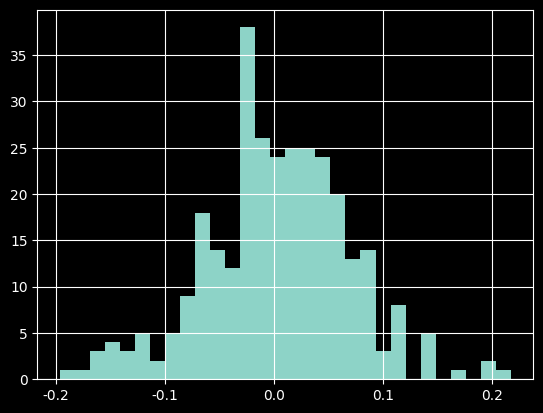

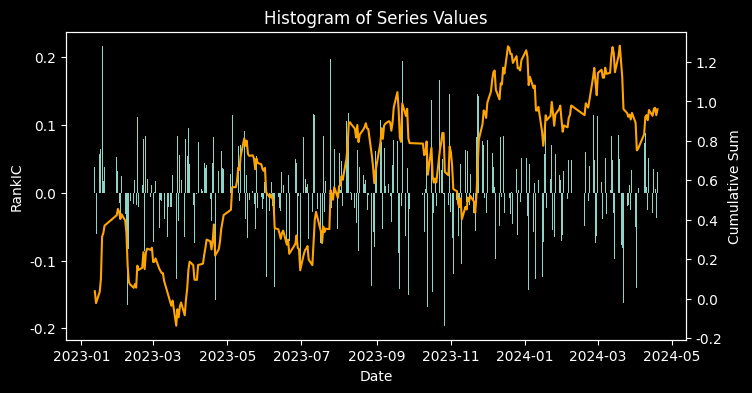

In [ ]:
Backtest_Indexes(AGRU_factor_backtest, profit_long_AGRU)

### Correlation

##### 1. Factor Correlation

In [ ]:
def Factor_Correlation(*Factor_df, type_list):
    # Factor cross-sectional correlation
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            temp_df.corrwith(Factor_df[j], axis=1).plot(label=f'{type_list[i]} & {type_list[j]}',
                                                        legend=True)
    plt.title(f"Correlation of Daily Factor Values")
    plt.legend(title="Factors", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

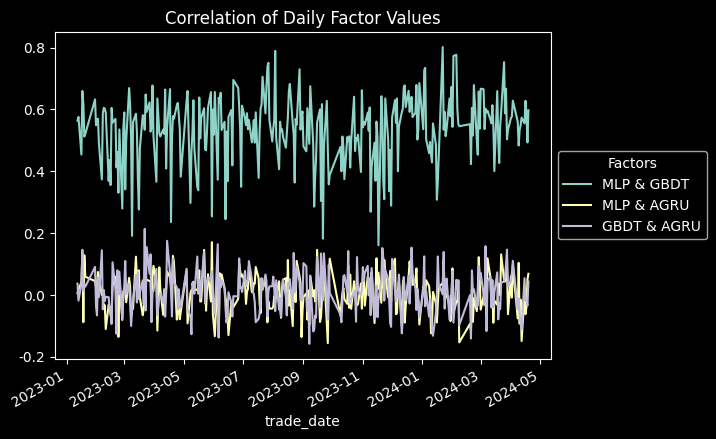

In [ ]:
Factor_Correlation(MLP_factor_backtest, 
                   GBDT_factor_backtest, 
                   AGRU_factor_backtest,
                   type_list=["MLP", "GBDT", "AGRU"])

In Python, `*args` and `**kwargs` are used to pass a variable number of arguments to a function.

- `*args`: The `*args` parameter in a function definition allows you to pass a variable number of positional arguments. When you use `*args` in a function definition, it collects all the positional arguments passed to the function into a tuple. You can then iterate over this tuple to access each argument.

Example:
```python
def my_function(*args):
    for arg in args:
        print(arg)

my_function('apple', 'banana', 'cherry')
```

Output:
```
apple
banana
cherry
```

- `**kwargs`: The `**kwargs` parameter in a function definition allows you to pass a variable number of keyword arguments. When you use `**kwargs` in a function definition, it collects all the keyword arguments passed to the function into a dictionary where the keys are the argument names and the values are the argument values.

Example:
```python
def my_function(**kwargs):
    for key, value in kwargs.items():
        print(f"{key}: {value}")

my_function(fruit='apple', color='red', price=1.00)
```

Output:
```
fruit: apple
color: red
price: 1.00
```

By using `*args` and `**kwargs`, you can create functions that are flexible and can accept a varying number of arguments, both positional and keyword arguments.

##### 2. Average IC Correlation

In [ ]:
def Factor_Correlation(*Factor_df, type_list):
    # Factor cross-sectional correlation
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            temp_df.corrwith(Factor_df[j], axis=1).plot(label=f'{type_list[i]} & {type_list[j]}',
                                                        legend=True)
    plt.title(f"Correlation of Daily Factor Values")
    plt.legend(title="Factors", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

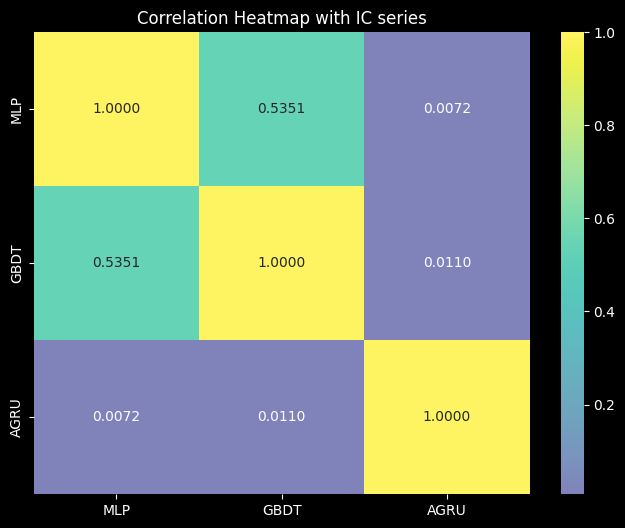

In [ ]:
def Average_IC_Correlation(*Factor_df, type_list):
    # Average Factor cross-sectional correlatcolumnsion
    matrix = pd.DataFrame(index=type_list, columns=type_list)
    np.fill_diagonal(matrix.values, 1) # Assign it with unit matrix
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            corr = temp_df.corrwith(Factor_df[j], axis=1).mean()
            # This is a symmetric matrix.
            matrix.iat[i, j] = corr
            matrix.iat[j, i] = corr
    return matrix
Average_IC_matrix = Average_IC_Correlation(
    MLP_factor_backtest,
    GBDT_factor_backtest,
    AGRU_factor_backtest,
    type_list=["MLP", "GBDT", "AGRU"],
)
# Convert data type of Average_IC_matrix to float for heatmap
Average_IC_matrix = Average_IC_matrix.astype(float)

# Create a heatmap
plt.figure(figsize=(8, 6))

# Create a custom color map with reduced brightness based on 'viridis'
viridis_cmap = plt.colormaps.get_cmap('viridis')
new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
custom_cmap = sns.color_palette(new_colors)

sns.heatmap(Average_IC_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
plt.title('Correlation Heatmap with IC series')
plt.show()

##### 3. IC series Correlation

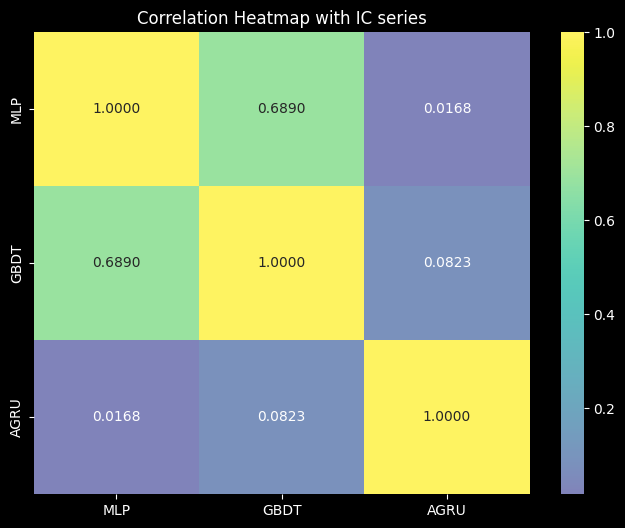

In [ ]:
def IC_Correlation(*factor_df, price_return, type_list):
    # Correlation of factor IC series
    Correlation_df = None
    for factor in factor_df:
        Corr = factor.corrwith(price_return, axis=1)
        Correlation_df = pd.concat([Correlation_df, Corr], axis=1)
    # Change the columns to type_list
    Correlation_df.columns = type_list
    return Correlation_df

IC_Correlation_df = IC_Correlation(
    MLP_factor_backtest,
    GBDT_factor_backtest,
    AGRU_factor_backtest,
    price_return=price_return_backtest,
    type_list=["MLP", "GBDT", "AGRU"],
)
IC_Correlation_matrix = IC_Correlation_df.corr()
# Create a heatmap
plt.figure(figsize=(8, 6))

# Create a custom color map with reduced brightness based on 'viridis'
viridis_cmap = plt.colormaps.get_cmap('viridis')
new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
custom_cmap = sns.color_palette(new_colors)

sns.heatmap(IC_Correlation_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
plt.title('Correlation Heatmap with IC series')
plt.show()